** In this exercise were going to represent an image with its principle components using the PCA algorithm<br> **
** I will implement the algorithm first with `numpy` <br> afterwards I will implement a vectorized version with `tensorflow` <br> The vectorized version will allow me to process multiple image on the GPU in parallel**

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os

/home/mohammad_14aug/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/mohammad_14aug/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline
%config IPCompleter.greedy = True

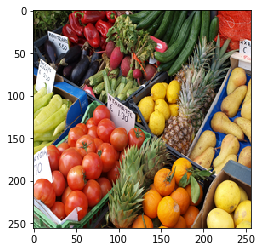

In [3]:
img = Image.open('samples/sample.jpg')
img = img.resize((256, 256), Image.ANTIALIAS)
image = np.asarray(img).astype(float) / 255
plt.imshow(image)
plt.show()
height, width, _ = np.shape(image)
image= np.expand_dims(image, axis = 0)

** The Principal Component Analysis algorithm is usually used to visualize the relationship between data when the data lies in a very high dimensional vector space.<br> The algorithm transforms the data into a vector space which eigenvectors and eigenvalues are derived from the Covariance matrix of our data points. Then if the purpose is to visualize the relationship between data points, the top N  $(N \leq 3)$ eigenvectors are used to transform our data points into a N-dimensional vector space which best represents our data.**
** Here are the steps required to compute the principal components of our data **

1. take the matrix of data points X, where X has M rows and N columns. M is the number of points and N is the number of dimensions of our data<br><br>
2. subtract the mean of each column from it. in some occassions it is better to to also divide each column by its variance. call this matrix $X_n$. The combination of these two steps is called data Normalization and is required to stabilize the training data <br><br>
3. multiply $X_n$ by its transpose. this is the covariance matrix. lets call it C. So we have: <br><br>.
$$ C = X_n X_n^t $$ <br><br>

4. compute the Eigenvectors and Eigenvalues of the covariance matrix. They can be computed using many mathematical libraries including the `np.linalg.eig` function in the numpy package and the `tf.linalg.eigh` function in the tensorflow framework. The Eigenvectors are a $N \times N$ matrix whereas eigenvalues is a $N \times 1$ sized vector where each cell of the vector represents the importance of its corresponding eigenvector <br><br>

`When we say more important eigenvectors, what we mean is eigenvectors that are able to capture a bigger snapshot of the variance of our data, if we were to represent our data along that eigenvector.`

5. sort The eigenvectors in descending order by the size of their corresponding eigenvalues and multiply our data by the top-K sorted eigenvectors where we usually have $K \leq 3$. And This is it! 

The eigenvectors are: 
 [[-0.66667604 -0.66491008  0.33680505]
 [-0.61596952  0.23706368 -0.75125386]
 [-0.41967202  0.7083046   0.56760902]] 


And their corresponding eigenvalues are: 
  [9685.49894907 2587.2688988   635.19227244] 




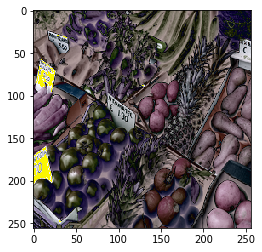

In [4]:
def apply_pca_numpy(image):
    image_vectorized = np.reshape(image, (256 * 256, 3))
    mean = np.mean(image_vectorized, axis = 0)
    image_normalized = (image_vectorized - mean)

    covariance_matrix = np.matmul(np.transpose(image_normalized), image_normalized)

    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)


    dictionary = {}
    eigen_vectors_sorted = np.zeros((3, 3), np.float)
    for i in range(3):
        dictionary[eigen_values[i]] = i
    sorted_keys = sorted(list(dictionary.keys()), reverse=True)
    for i in range(3):
        eigen_vectors_sorted[:, i] = eigen_vectors[:, dictionary[sorted_keys[i]]]

    print("The eigenvectors are: \n", eigen_vectors_sorted, '\n\n')
    print("And their corresponding eigenvalues are: \n ", eigen_values, '\n\n')
    #eigen_vectors_sorted = np.abs(eigen_vectors_sorted)
    output = np.matmul(image_normalized, np.abs(eigen_vectors_sorted))
    output_image = np.abs(np.reshape(output, (256, 256, 3)))
    plt.imshow(output_image)
    plt.show()
    return output_image

image_after_pca = apply_pca_numpy(image)


** Its much more efficient to vectorize our computations on GPU to process multiples image in parallel. Im gonna implement the PCA algorithm with tensorflow-gpu and process all my sample images in one run in parallel **

In [5]:
def apply_pca_gpu(images):
    num_images = np.shape(images)[0]
    tf_image = tf.placeholder(dtype=tf.float32, shape=[num_images,256, 256, 3], name='image')
    image_vectorized = tf.reshape(tf_image, shape=[num_images,256 * 256, 3], name='image_vectorized')
    mean, _ = tf.nn.moments(image_vectorized, axes = 1)
    image_normalized = [[[0 for i in range(3)] for j in range(256 * 256)] for k in range(num_images)]
    for i in range(num_images):
        image_normalized[i] = (image_vectorized[i] - mean[i])
    
    covariance_matrix = tf.matmul(image_normalized, image_normalized, transpose_a=True, name='co_matrix')
    eigen_values, eigen_vectors = tf.linalg.eigh(covariance_matrix, name='eigen_decomp')
    
    eigen_vectors_t = tf.transpose(eigen_vectors, [0, 2, 1])
    
    eigen_vectors_sorted = [[[0 for i in range(3)] for j in range(3)] for k in range(num_images)]
    for i in range(num_images):
        for j in range(3):
            eigen_vectors_sorted[i][j] = eigen_vectors_t[i][2- j]
    eigen_vectors_sorted = tf.transpose(eigen_vectors_sorted, [0, 2, 1])
    
    output = tf.matmul(image_normalized, tf.abs(eigen_vectors_sorted))
    output_image = tf.abs(tf.reshape(output, (num_images, 256, 256, 3)))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        eigen_values, eigen_vectors_sorted, output = sess.run([eigen_values,eigen_vectors_sorted,
                                                               output_image], feed_dict={tf_image : images})
    return eigen_values, eigen_vectors_sorted, output


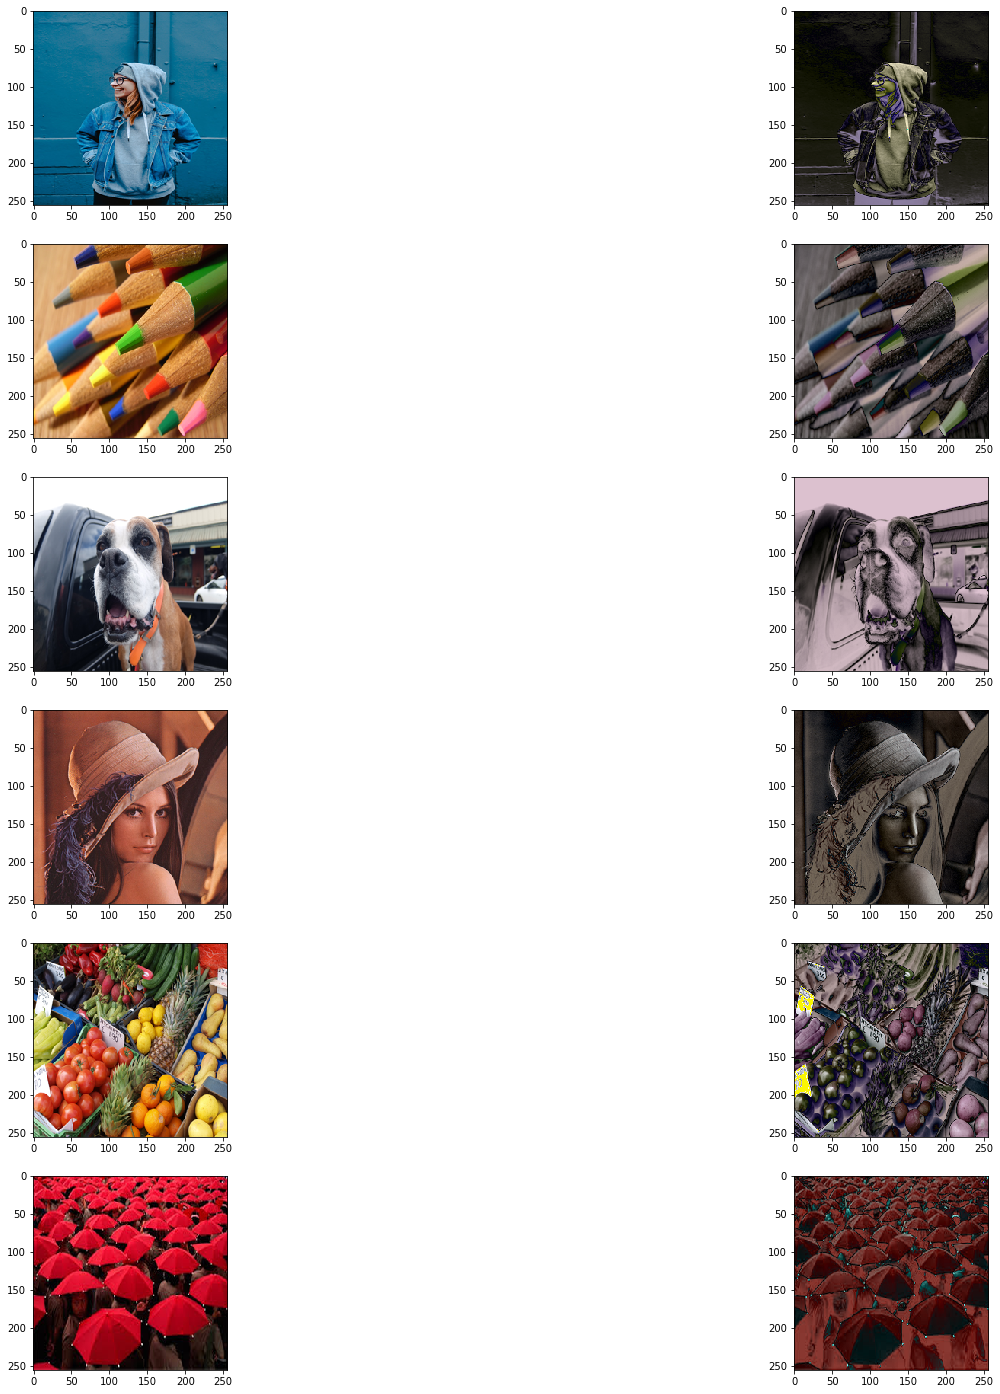

In [6]:
images = []
os.chdir('/home/mohammad_14aug/ComputerVisionExercises/Exercise 3/samples')
files = os.listdir()
for file in files:
    img = Image.open(file)
    img = img.resize((256, 256), Image.ANTIALIAS)
    image = np.asarray(img).astype(float) / 255
    images.append(image)
eigen_values, eigen_vectors, images_after_pca = apply_pca_gpu(images)
f, axarr = plt.subplots(len(images_after_pca),2)
f.set_figheight(25)
f.set_figwidth(25)
for i in range(len(images_after_pca)):
    axarr[i,0].imshow(images[i][:][:][:])
    axarr[i,1].imshow(images_after_pca[i][:][:][:])

** The results are not very outstanding, as I expected it to be. it is usually not a very good idea to use PCA in image processing tasks as our data already lies in a 3-D vector space, whereas PCA is usually used to visualize the relationship between n-dimensional data when n is very large. A better approach for extracting important image color data would be to use the K-means clustering algorithm. in the next notebook i will implement this algorithm on the same samples so we can compare the results. **